In [ ]:
import gdown
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pprint
import random
import pandas as pd
import pulp
import itertools
import requests
import random
from geopy.distance import geodesic
import time
import pandas as pd
import os

Downloading...
From (original): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf
From (redirected): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf&confirm=t&uuid=828f2f53-7291-44ef-a14e-e1a208d7ef62
To: /content/mpsis_setup.py
100%|██████████| 12.1k/12.1k [00:00<00:00, 21.4MB/s]


Mounted at /content/drive


In [ ]:
def generate_random_point(sw_lat, sw_lng, ne_lat, ne_lng):
    lat = random.uniform(sw_lat, ne_lat)
    lng = random.uniform(sw_lng, ne_lng)
    return lat, lng

def snap_to_road(lat, lng, api_key):
    url = f'https://roads.googleapis.com/v1/nearestRoads?points={lat},{lng}&key={api_key}'
    response = requests.get(url)
    data = response.json()
    if 'snappedPoints' in data and len(data['snappedPoints']) > 0:
        snapped_point = data['snappedPoints'][0]['location']
        return snapped_point['latitude'], snapped_point['longitude']
    return None

def get_road_distance_time(origin, destination, api_key):
    origin_str = f'{origin[0]}, {origin[1]}'
    destination_str = f'{destination[0]}, {destination[1]}'
    departure_time = int(time.time()) + 24 * 3600
    url = (
        f'https://maps.googleapis.com/maps/api/distancematrix/json?units=metric&origins={origin_str}'
        f'&destinations={destination_str}&mode=driving&departure_time={departure_time}&key={api_key}'
    )
    response = requests.get(url)
    data = response.json()

    if data['status'] == 'OK':
        element = data['rows'][0]['elements'][0]
        if element['status'] == 'OK':
            distance_text = element['distance']['text']
            distance = float(distance_text.replace(' km', '').replace(',', ''))

            duration_text = element['duration']['text']
            duration_parts = duration_text.split()
            duration = int(duration_parts[0])
            if "hour" in duration_text:
                duration = int(duration_parts[0]) * 60 + int(duration_parts[2])

            return distance, duration
        else:
            return None, None
    else:
        return None, None

def find_center(sw_lat, sw_lng, ne_lat, ne_lng):
    center_lat = (sw_lat + ne_lat) / 2
    center_lng = (sw_lng + ne_lng) / 2
    return center_lat, center_lng

def generate_list(n, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")
    result = [0]
    random_values = np.random.rand(n - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    result.extend(rounded_values)

    return result

def crop_matrix(data, N):
    return [row[:N] for row in data[:N]]

In [ ]:
df = pd.read_csv(os.path.join("", "FILE"))

In [ ]:
real_distance_columns = [col for col in df.columns if col.startswith('Road Distance to Point')]
df_filtered = df[real_distance_columns]

num_points = len(df_filtered)
cost = [[0] * num_points for _ in range(num_points)]

for i in range(num_points):
    for j in range(num_points):
        if i != j:
            column_name = f'Road Distance to Point {j + 1}'
            distance = df_filtered.iloc[i][column_name]

            cost[i][j] = float(distance)


print("Cost matrix:")
for row in cost:
    print(f"{row},")

real_distance_columns = [col for col in df.columns if col.startswith('Time to Point')]
df_filtered = df[real_distance_columns]

num_points = len(df_filtered)
T = [[0] * num_points for _ in range(num_points)]

for i in range(num_points):
    for j in range(num_points):
        if i != j:
            column_name = f'Time to Point {j + 1}'
            distance = df_filtered.iloc[i][column_name]

            T[i][j] = float(distance)

Cost matrix:
[0, 288, 135, 188, 315, 503, 95, 467, 534, 436, 629, 140, 773, 804, 584, 115, 567, 511, 523, 490, 320],
[288, 0, 242, 422, 564, 733, 377, 760, 768, 729, 855, 206, 1008, 1030, 878, 325, 802, 642, 794, 722, 659],
[135, 242, 0, 320, 364, 631, 230, 592, 666, 561, 761, 35, 905, 936, 710, 223, 699, 639, 626, 619, 556],
[188, 422, 320, 0, 495, 427, 246, 438, 358, 546, 453, 275, 597, 627, 536, 150, 391, 435, 621, 311, 248],
[315, 564, 364, 495, 0, 811, 314, 351, 758, 210, 801, 380, 707, 880, 474, 465, 571, 819, 298, 584, 361],
[503, 733, 631, 427, 811, 0, 563, 700, 320, 831, 329, 587, 672, 564, 606, 400, 493, 216, 905, 369, 476],
[95, 377, 230, 246, 314, 563, 0, 404, 449, 372, 544, 230, 755, 719, 521, 175, 593, 572, 460, 405, 263],
[467, 760, 592, 438, 351, 700, 404, 0, 424, 150, 466, 605, 364, 546, 140, 573, 237, 858, 225, 412, 198],
[534, 768, 666, 358, 758, 320, 449, 424, 0, 558, 57, 623, 400, 293, 334, 499, 220, 511, 599, 96, 324],
[436, 729, 561, 546, 210, 831, 372, 150, 558,

In [ ]:
import numpy as np

def generate_demand_list(n, m, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if m >= n:
        raise ValueError("M must be less than N.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")

    random_values = np.random.rand(n - m - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    zeros_list = [0] * m

    result = list(rounded_values) + zeros_list

    random.shuffle(result)

    result = [-1] + result

    return result

def replace_zeros_with_sum(input_list, target_sum):
    zero_positions = [i for i, value in enumerate(input_list) if value == 0]
    num_zeros = len(zero_positions)

    result = input_list.copy()

    if num_zeros == 0:
        raise ValueError("There are no zeros to replace in the list.")

    random_values = np.random.rand(num_zeros)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    for i, pos in enumerate(zero_positions):
        result[pos] = rounded_values[i]

    return result



In [ ]:
number_of_clients = 15
Q = 100
m = 3

nof_pickup_clients = list(range(3,14))
cost_vrpsdp = [[] for _ in range(len(nof_pickup_clients))]
cost_vrpb = [[] for _ in range(len(nof_pickup_clients))]
cost_shiffted = crop_matrix(cost, number_of_clients + 1)

for num_of_pickups in nof_pickup_clients:
    print(f" %%%%%%%%%%%%%%%%%%%%% number_of_pickups_clients {num_of_pickups}")
    which_list_to_add = nof_pickup_clients.index(num_of_pickups)
    for trial in range(20):
        print(f" trial_number {trial}")

        d = generate_demand_list(number_of_clients + 1, num_of_pickups, 0.5 * Q * m)
        p_d = replace_zeros_with_sum(d, 0.5 * Q * m)
        p = [-1]

        for iterator in range(1,len(d)):
          if d[iterator] == 0:
            p.append(p_d[iterator])
          else:
            p.append(0)

        vrpsdp = pulp.LpProblem("VRPSDP", pulp.LpMinimize)

        x = pulp.LpVariable.dicts("x", [(i, j, k) for i in range(number_of_clients+1) for j in range(number_of_clients+1) for k in range(m)], cat='Binary')
        y = pulp.LpVariable.dicts("y", [(i, j) for i in range(number_of_clients+1) for j in range(number_of_clients+1)], lowBound=0, cat='Continuous')
        z = pulp.LpVariable.dicts("z", [(i, j) for i in range(number_of_clients+1) for j in range(number_of_clients+1)], lowBound=0, cat='Continuous')

        vrpsdp += pulp.lpSum(cost_shiffted[i][j] * x[i, j, k] for k in range(m) for i in range(number_of_clients+1) for j in range(number_of_clients+1) if i != j)


        for j in range(1, number_of_clients+1):
            vrpsdp += pulp.lpSum(x[i, j, k] for k in range(m) for i in range(number_of_clients+1) if i != j) == 1

        for k in range(m):
          for j in range(number_of_clients+1):
            vrpsdp += pulp.lpSum(x[i,j,k] for i in range(number_of_clients+1)) - pulp.lpSum(x[j,i,k] for i in range(number_of_clients+1)) == 0

        for k in range(m):
          vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, number_of_clients+1)) == 1


        for j in range(1, number_of_clients+1):
          vrpsdp += pulp.lpSum(y[j,i] for i in range(number_of_clients+1)) - pulp.lpSum(y[i,j] for i in range(number_of_clients+1)) == p[j]

        for j in range(1, number_of_clients+1):
          vrpsdp += pulp.lpSum(z[i,j] for i in range(number_of_clients+1)) - pulp.lpSum(z[j,i] for i in range(number_of_clients+1)) == d[j]

        for i in range(number_of_clients+1):
          for j in range(number_of_clients+1):
            if i != j:
              vrpsdp += y[i,j] + z[i,j] <= Q * pulp.lpSum(x[i,j,k] for k in range(m))

        vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, number_of_clients+1) for k in range(m)) == m
        for i in range(1,number_of_clients+1):
          vrpsdp += pulp.lpSum(x[i,j,k] for j in range(number_of_clients+1) for k in range(m) if i != j) == 1

        vrpsdp.solve()

        cost_vrpsdp[which_list_to_add].append(pulp.value(vrpsdp.objective))

        L_B = list(range(1, number_of_clients + 1))
        SOURCE = 0

        L = [index for index, value in enumerate(p) if value == 0]
        L0 = L[:]
        L0.insert(0,0)
        B = [index for index, value in enumerate(d) if value == 0]

        B0 = B[:]
        B0.insert(0,0)
        Cu = L_B

        V = list(range(0, number_of_clients + 1))

        K = m

        D = p_d

        Kl = K
        Kb = K

        s = pulp.LpVariable.dicts('s', [(i, j) for i in V for j in V if i != j], cat = pulp.LpBinary)
        e = pulp.LpVariable.dicts('e', [(i, j) for i in L for j in B0 if i != j], cat = pulp.LpBinary)
        l = pulp.LpVariable.dicts('l', [(i, j) for i in V for j in V if i != j], 0, cat = "Continuous")

        model = pulp.LpProblem("vehicle_routing", pulp.LpMinimize)

        cost_function_model = pulp.lpSum(s[i,j] * cost_shiffted[i][j] for i in V for j in V if i != j) + pulp.lpSum(e[i,j] * cost[i][j] for i in L for j in B0 if i != j)
        model += cost_function_model

        model += pulp.lpSum(s[i,j] for i in L0 for j in L if i != j) == len(L)

        for j in L:
          model += pulp.lpSum(l[i,j] for i in L0 if i != j) - pulp.lpSum(l[j,k] for k in L0 if k != j) == D[j]

        for j in L:
          model += pulp.lpSum(s[i,j] for i in L0 if i != j) == 1

        for j in L:
          model += pulp.lpSum(s[j,k] for k in L if k != j) + pulp.lpSum(e[j,k] for k in B0 if k != j)  ==  pulp.lpSum(s[(i,j)] for i in L0 if i != j)

        for j in L:
          for i in L0:
            if i != j:
              model += l[(i,j)] <= Q * s[(i,j)]

        fraaction7 = pulp.lpSum(D[j] for j in L)/Q
        model += pulp.lpSum(s[0,j] for j in L) >= max(float(fraaction7.value()),Kl)

        model += pulp.lpSum(s[i,j] for i in B for j in B0 if i != j) == len(B)

        for j in B:
          model += pulp.lpSum(l[i,j] for i in B if i != j) - pulp.lpSum(l[(j,k)] for k in B0 if k != j) == -D[j]

        for j in B:
          model += pulp.lpSum(s[j,i] for i in B0 if j != i) == 1

        for j in B:
          model += pulp.lpSum(s[k,j] for k in B if k != j) + pulp.lpSum(e[k,j] for k in L) == pulp.lpSum(s[(j,i)] for i in B0 if j != i)

        for j in B0:
          for i in B:
            if i != j:
              model += l[i,j] <= Q * s[i,j]

        fraaction13 = pulp.lpSum(D[j] for j in B)/Q
        model += max(int(fraaction13.value()),Kb) <= pulp.lpSum(s[i,0] for i in B)
        model += pulp.lpSum(s[(i,0)] for i in B) <= pulp.lpSum(s[0, j] for j in L)

        model += pulp.lpSum(s[i,0] for i in B) + pulp.lpSum(e[i, 0] for i in L) == pulp.lpSum(s[0,j] for j in L)

        for i in V:
          for j in V:
            if i != j:
              model += s[i,j] + s[j,i] <= 1

        model += pulp.lpSum(s[i,j] for i in B for j in L if i != j) == 0

        model += pulp.lpSum(s[0, j] for j in B) == 0

        model += pulp.lpSum(s[i,j] for i in L for j in B0 if i != j) == 0

        model.solve()

        cost_vrpb[which_list_to_add].append(pulp.value(model.objective))

In [ ]:
cost_vrpsdp =  [[4081.0, 3495.0, 3495.0, 3495.0, 3556.0, 3495.0, 3495.0, 3495.0, 3552.0, 3495.0, 3513.0, 3835.0, 3495.0, 3495.0, 3513.0, 3495.0, 3495.0, 3495.0, 3681.0, 3556.0], [3513.0, 3513.0, 3640.0, 3878.0, 3513.0, 3541.0, 3495.0, 3495.0, 3505.0, 3495.0, 3495.0, 3495.0, 3640.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3773.0, 3570.0], [3513.0, 3556.0, 3556.0, 3495.0, 3505.0, 3495.0, 3495.0, 3675.0, 3495.0, 3495.0, 3495.0, 3556.0, 3570.0, 3495.0, 3495.0, 3541.0, 3495.0, 3495.0, 3505.0, 3495.0], [3513.0, 3767.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3556.0, 3495.0, 3541.0, 3513.0, 3495.0, 3495.0, 3495.0, 3495.0, 3570.0], [3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3570.0, 3495.0, 3495.0, 3552.0, 3513.0, 3495.0, 3495.0, 3513.0, 3495.0], [3556.0, 3495.0, 3541.0, 3892.0, 3495.0, 3495.0, 3505.0, 3495.0, 3570.0, 3495.0, 3495.0, 3513.0, 3495.0, 3495.0, 3495.0, 3681.0, 3495.0, 3495.0, 3681.0, 3495.0], [3773.0, 3556.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3541.0, 3495.0, 3495.0, 3835.0, 3556.0, 3495.0, 3495.0, 3556.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3541.0, 3629.0, 3513.0, 4471.0, 4472.0], [3570.0, 3495.0, 3495.0, 3505.0, 3495.0, 3541.0, 3495.0, 3495.0, 3629.0, 3495.0, 3829.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3505.0, 3552.0, 3984.0], [3495.0, 3505.0, 3495.0, 3570.0, 3495.0, 3495.0, 3495.0, 3681.0, 3495.0, 3513.0, 3556.0, 3495.0, 3835.0, 3505.0, 3495.0, 3495.0, 3495.0, 3495.0, 3570.0, 3495.0], [3570.0, 3681.0, 3495.0, 3546.0, 3936.0, 3513.0, 3681.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3570.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0, 3495.0], [3835.0, 3681.0, 3541.0, 3681.0, 3495.0, 3505.0, 3495.0, 3681.0, 3997.0, 3681.0, 3495.0, 3681.0, 3495.0, 3570.0, 3495.0, 3495.0, 4291.0, 3495.0, 3495.0, 3495.0]]
cost_vrpb = [[4699.0, 3984.0, 4320.0, 4318.0, 4099.0, 3773.0, 4099.0, 4022.0, 4315.0, 3958.0, 4422.0, 4650.0, 4152.0, 4412.0, 4473.0, 4324.0, 3962.0, 3600.0, 4356.0, 4318.0], [3597.0, 4461.0, 3793.0, 3997.0, 4406.0, 4614.0, 4248.0, 4015.0, 3942.0, 4486.0, 4528.0, 4065.0, 4459.0, 4293.0, 4346.0, 3999.0, 4419.0, 4124.0, 4619.0, 4169.0], [4294.0, 3722.0, 4715.0, 4398.0, 4289.0, 4214.0, 4421.0, 4401.0, 4499.0, 4401.0, 4115.0, 4036.0, 4659.0, 4022.0, 4396.0, 4483.0, 4383.0, 4530.0, 4396.0, 4068.0], [4443.0, 4662.0, 4372.0, 3977.0, 4448.0, 3629.0, 4370.0, 4286.0, 4489.0, 4336.0, 4569.0, 4658.0, 4245.0, 4372.0, 4421.0, 4467.0, 4367.0, 4480.0, 4357.0, 4368.0], [4388.0, 4448.0, 3681.0, 4316.0, 4307.0, 4536.0, 4419.0, 4440.0, 4669.0, 4475.0, 4402.0, 4259.0, 4500.0, 4591.0, 4641.0, 3747.0, 4517.0, 3979.0, 4491.0, 4243.0], [4417.0, 4366.0, 4586.0, 4433.0, 4476.0, 4405.0, 4348.0, 3969.0, 4012.0, 4550.0, 4481.0, 4115.0, 4424.0, 4326.0, 4415.0, 4476.0, 3934.0, 4468.0, 4134.0, 4423.0], [4593.0, 4630.0, 4369.0, 4334.0, 4313.0, 4133.0, 4357.0, 4587.0, 4471.0, 4181.0, 4364.0, 4609.0, 4349.0, 4438.0, 4443.0, 4456.0, 4427.0, 3701.0, 4491.0, 4486.0, 4245.0, 4499.0, 3984.0, 4136.0, 4301.0, 5272.0, 5527.0], [4353.0, 4655.0, 4501.0, 4252.0, 4444.0, 4639.0, 4528.0, 4114.0, 4077.0, 4318.0, 4615.0, 4012.0, 4410.0, 4351.0, 4297.0, 4306.0, 3739.0, 4559.0, 4669.0, 4461.0], [4522.0, 4106.0, 3662.0, 4539.0, 4561.0, 4569.0, 4053.0, 4435.0, 4588.0, 4642.0, 4332.0, 4117.0, 4650.0, 4160.0, 4366.0, 4413.0, 4407.0, 4561.0, 4113.0, 4093.0], [4514.0, 4268.0, 3556.0, 4409.0, 4406.0, 4422.0, 4217.0, 4044.0, 4025.0, 4148.0, 4158.0, 4446.0, 4025.0, 3722.0, 4243.0, 4554.0, 3701.0, 4632.0, 4153.0, 4159.0], [4170.0, 4025.0, 3997.0, 4356.0, 4161.0, 3570.0, 4040.0, 4120.0, 4356.0, 4134.0, 4318.0, 4413.0, 4144.0, 3951.0, 3722.0, 4359.0, 4631.0, 3585.0, 3722.0, 4035.0]]

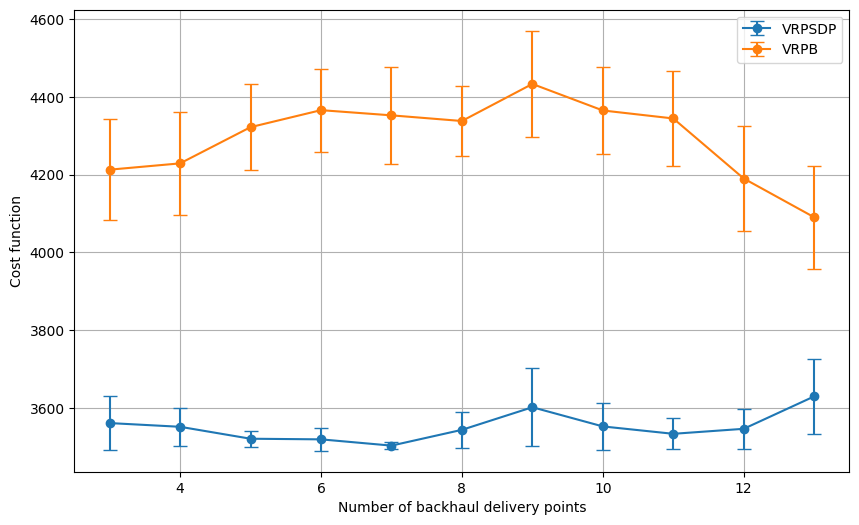

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

vrpsdp_mean = []
vrpsdp_conf_intervals = []
nof_pickup_clients = list(range(3, 14))

for vrpsdp in cost_vrpsdp:
    numeric_values = [x for x in vrpsdp if x is not None]
    mean_val = np.mean(numeric_values)
    std_dev = np.std(numeric_values, ddof=1)
    n = len(numeric_values)
    df = n - 1
    t_value = stats.t.ppf(1 - 0.025, df)
    ci = t_value * std_dev / np.sqrt(n)

    vrpsdp_mean.append(mean_val)
    vrpsdp_conf_intervals.append(ci)

vrpb_mean = []
vrpb_conf_intervals = []

for vrpb in cost_vrpb:
    numeric_values = [x for x in vrpb if x is not None]
    mean_val = np.mean(numeric_values)
    std_dev = np.std(numeric_values, ddof=1)
    n = len(numeric_values)
    df = n - 1
    t_value = stats.t.ppf(1 - 0.025, df)
    ci = t_value * std_dev / np.sqrt(n)

    vrpb_mean.append(mean_val)
    vrpb_conf_intervals.append(ci)

plt.figure(figsize=(10, 6))

plt.errorbar(nof_pickup_clients, vrpsdp_mean,
             yerr=vrpsdp_conf_intervals, fmt='-o', capsize=5, label='VRPSDP')
plt.errorbar(nof_pickup_clients, vrpb_mean,
             yerr=vrpb_conf_intervals, fmt='-o', capsize=5, label='VRPB')

plt.xlabel('Number of backhaul delivery points')
plt.ylabel('Cost function')
plt.legend()
plt.grid(True)
plt.show()
